In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_palette('deep')

In [118]:
from pathlib import Path
folder = Path("/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid")
files = [f for f in folder.glob("*.csv")]
files

[PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v2_task-5nze.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v2_task-wxlw.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v2_task-rmzj.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v5_task-co2r.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v2_task-co2r.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v4_task-co2r.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v2_task-3d8t.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v2_task-51v9.csv'),
 PosixPath('/Users/mn/Desktop/mooney_pilot/mooney/analysis/valid/data_exp_125158-v4_task-rmzj.csv')]

In [119]:
df = pd.DataFrame()
display_counts = []
names = []

for f in files:
    df_raw = pd.read_csv(f)
    display_counts.append(df_raw.display.value_counts())
    names.append(df_raw["Participant Public ID"].dropna().unique().item())

    df_raw.loc[(df_raw["answer"] == 'body(animal)'), 'answer'] = 'body (animal)' # fix typo

    df_s = (df_raw
            .loc[:, ['Trial Number', 'Screen Name', 'Reaction Time', 'Response', 'display', 'image', 'answer']]
            .drop(df_raw[df_raw["Zone Name"] == "timer"].index) # drop timer info
            .drop(df_raw[~df_raw["Screen Name"].isin(["Mooney", "grayscale"])].index) # keep trial screens only
            .assign(correct=lambda x: x.apply(lambda y: 1 if y['answer'] == y['Response'] else 0, axis=1))
            .assign(keyword=lambda x: x["image"].apply(lambda s: s.split("_")[1] 
                                                                    if (s.split("_")[0] == "dis")
                                                                    else s.split("_")[0]))
        )
    df = pd.concat([df, df_s], ignore_index=True)

# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Trial Number   3000 non-null   object 
 1   Screen Name    3000 non-null   object 
 2   Reaction Time  3000 non-null   float64
 3   Response       3000 non-null   object 
 4   display        3000 non-null   object 
 5   image          3000 non-null   object 
 6   answer         3000 non-null   object 
 7   correct        3000 non-null   int64  
 8   keyword        3000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 211.1+ KB


In [120]:
display_counts

[disambig        360
 post            356
 pre             355
 block            12
 instructions      1
 Name: display, dtype: int64,
 disambig        355
 post            346
 pre             342
 block            12
 instructions      1
 Name: display, dtype: int64,
 disambig        360
 post            335
 pre             312
 block            12
 instructions      1
 Name: display, dtype: int64,
 pre             360
 disambig        360
 post            359
 block            12
 instructions      1
 Name: display, dtype: int64,
 disambig        359
 pre             349
 post            349
 block            12
 instructions      1
 Name: display, dtype: int64,
 disambig        358
 post            356
 pre             353
 block            12
 instructions      1
 Name: display, dtype: int64,
 disambig        360
 pre             355
 post            348
 block            12
 instructions      1
 Name: display, dtype: int64,
 disambig        357
 pre             351
 post        

In [161]:
# global vars, plotting functions

CATEGORIES = sorted(df["answer"].unique())
KEYWORDS = sorted(df["keyword"].unique())

def plot_categories(df, title, cats=CATEGORIES, group=False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
    sns.barplot(x='answer', y='correct', data=df, errorbar=None, ax=ax1, order=cats, hue='display' if group else None)
    sns.boxplot(x='answer', y='Reaction Time', data=df, ax=ax2, order=cats, hue='display' if group else None)
    fig.suptitle(title)
    ax1.set(ylim=(0,1))
    ax2.set(ylim=(0,3500))  


def plot_keywords(df, title, words=KEYWORDS, group=False):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,25))
    sns.barplot(x='keyword', y='correct', data=df, errorbar=None, ax=ax1, order=words, hue='display' if group else None)
    sns.boxplot(x='keyword', y='Reaction Time', data=df, ax=ax2, order=words, hue='display' if group else None)
    fig.suptitle(title)
    ax1.set(ylim=(0,1))
    ax2.set(ylim=(0,3500))

    if group:
        for a in (ax1, ax2):
            a.set_xticklabels(a.get_xticklabels(), rotation=40, ha="right");

In [122]:
# check if all images were shown, drop if not - for V0 only

# checkdf = df.copy(deep=True)

# f = lambda s: s[4:] if s[:4] == "dis_" else s

# checkdf["image"] = checkdf["image"].apply(f)

# counts = checkdf["image"].value_counts()
# imgs_to_drop = list(counts[counts < 3].keys()) + list(map(lambda s: "dis_" + s, counts[counts < 3].keys()))

# df = df[~df["image"].isin(imgs_to_drop)]

# assert len(checkdf) == len(df) + sum(counts[counts < 3])
# print(f"imgs without a match ({len(imgs_to_drop)}): \n", imgs_to_drop)

In [123]:
pd.merge(
    df.loc[df["Reaction Time"] == max(df["Reaction Time"])],
    df.loc[df["Reaction Time"] == min(df["Reaction Time"])],
    how='outer'
)


,Trial Number,Screen Name,Reaction Time,Response,display,image,answer,correct,keyword
0,70,Mooney,2988.2,body (human),pre,tennis_player_40.jpg,body (human),1,tennis
1,98,Mooney,610.8,fruit / vegetable,post,pineapple_88.jpg,fruit / vegetable,1,pineapple


### overview

[(0.0, 3500.0)]

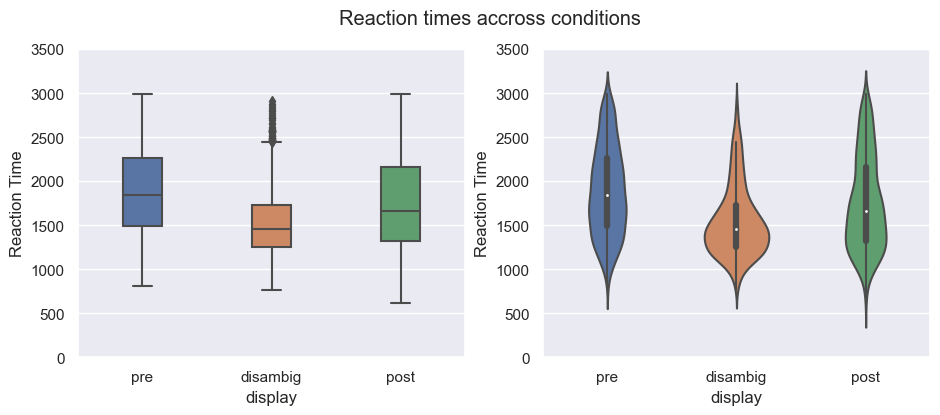

In [149]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))

box = sns.boxplot(x='display', y='Reaction Time', data=df, ax=ax1, width=.3)
violin = sns.violinplot(x='display', y='Reaction Time', data=df, ax=ax2, width=.5, inner='box')

fig.suptitle("Reaction times accross conditions")
ax1.set(ylim=(0,3500))
ax2.set(ylim=(0,3500))

Text(0.5, 0.98, 'Percent correct accross conditions')

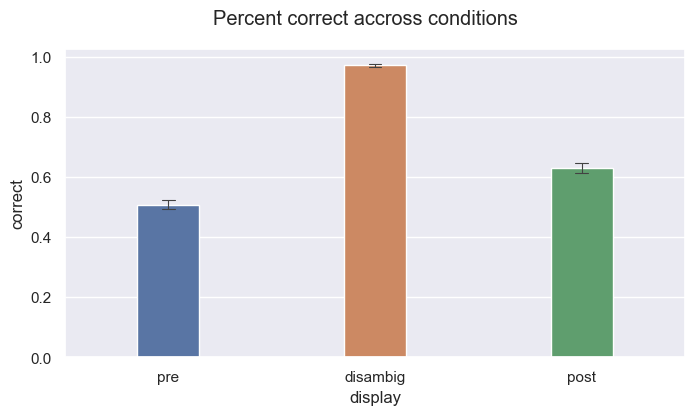

In [125]:
f,a = plt.subplots(figsize=(8,4))
bar = sns.barplot(x='display', y='correct', data=df, errorbar='se', capsize=.06, width=.3, errwidth=.8)
f.suptitle("Percent correct accross conditions")

Text(0.5, 0.98, 'Reaction times accross conditions, by category')

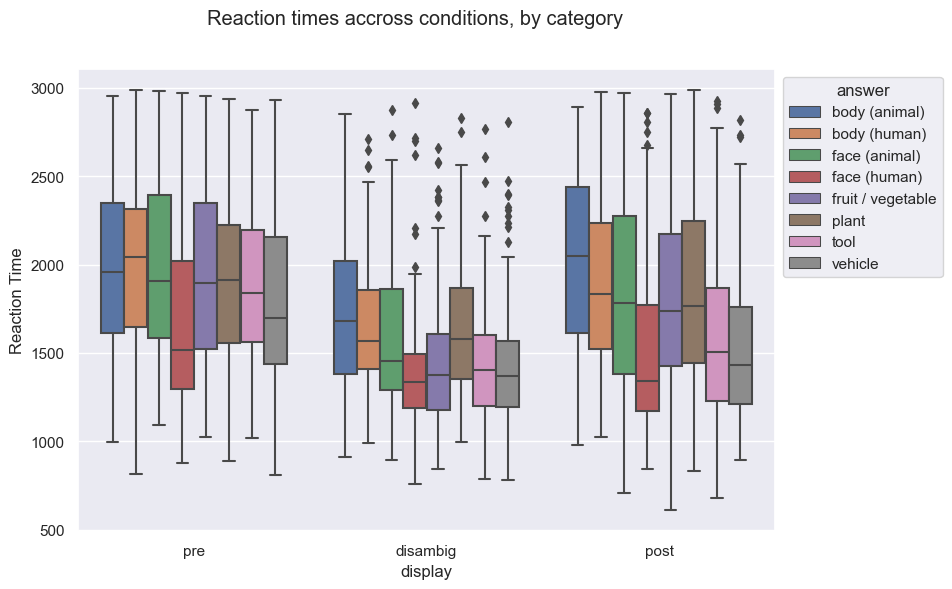

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
box = sns.boxplot(x='display', y='Reaction Time', data=df, ax=ax, width=.8, hue='answer', hue_order=CATEGORIES)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.suptitle("Reaction times accross conditions, by category")

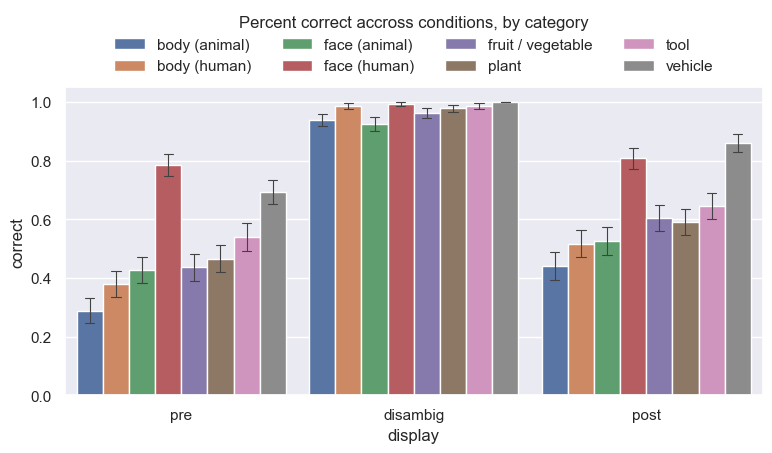

In [178]:
f,a = plt.subplots(figsize=(9,4))
sns.barplot(x='display', y='correct', data=df, hue='answer', hue_order=CATEGORIES, errorbar='se', capsize=.04, width=.9, errwidth=.8)
sns.move_legend(
    a, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title="Percent correct accross conditions, by category", frameon=False,
)

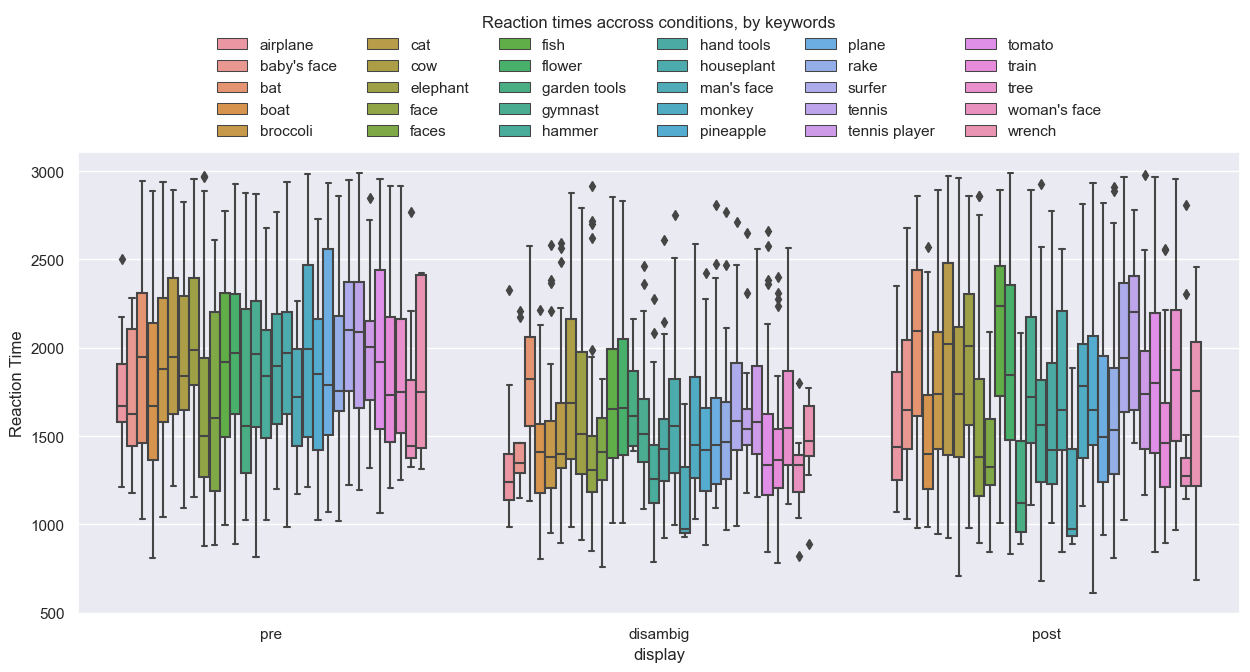

In [128]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
box = sns.boxplot(x='display', y='Reaction Time', data=df, ax=ax, width=.8, hue='keyword', hue_order=KEYWORDS)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title="Reaction times accross conditions, by keywords", frameon=False,
)

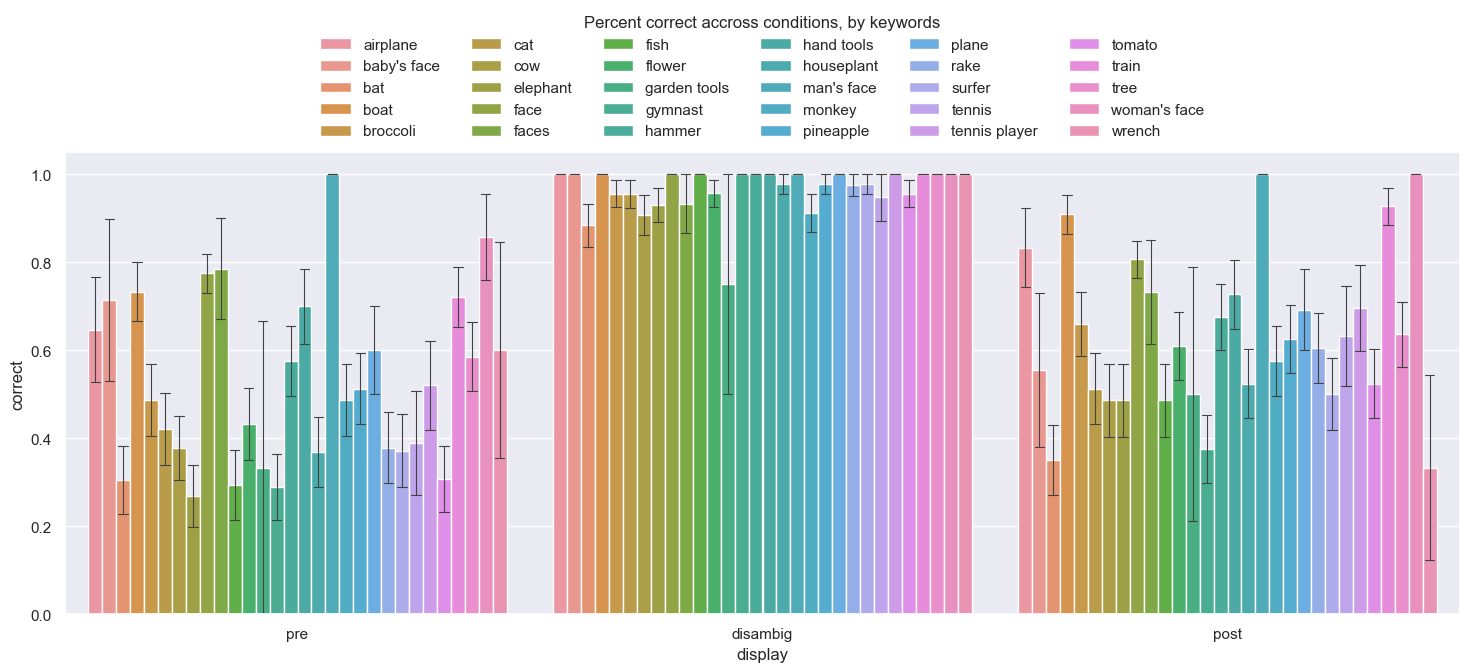

In [129]:
f,a = plt.subplots(figsize=(18,6))
sns.barplot(x='display', y='correct', data=df, hue='keyword', hue_order=KEYWORDS, errorbar='se', capsize=.02, width=.9, errwidth=.8)
sns.move_legend(
    a, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title="Percent correct accross conditions, by keywords", frameon=False,
)

In [ ]:
# ^ pool into groups (ideally same nr of search terms per cat)

### categories

[(0.0, 1.0)]

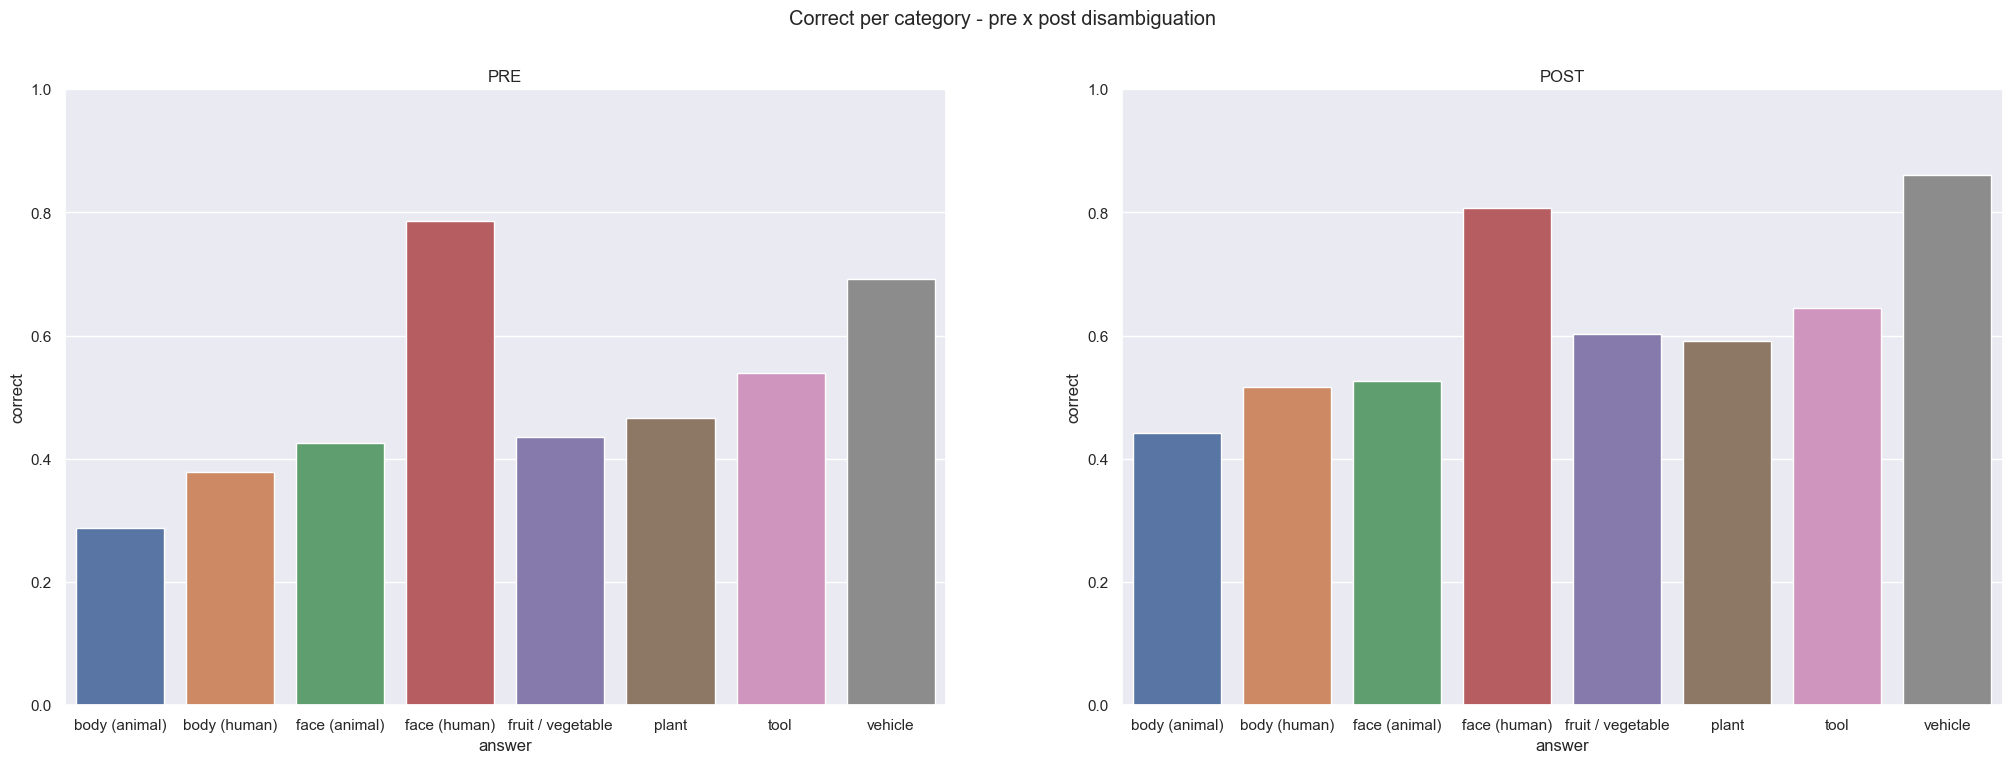

In [130]:
df_mooney_pre = df[(df["Screen Name"] == "Mooney") & (df["display"] == "pre")]
df_gray_disambig = df[(df["Screen Name"] == "grayscale") & (df["display"] == "disambig")]
df_mooney_post = df[(df["Screen Name"] == "Mooney") & (df["display"] == "post")]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
sns.barplot(x='answer', y='correct', data=df_mooney_pre, errorbar=None, ax=ax1, order=CATEGORIES).set(title="PRE")
sns.barplot(x='answer', y='correct', data=df_mooney_post, errorbar=None, ax=ax2, order=CATEGORIES).set(title="POST")
fig.suptitle("Correct per category - pre x post disambiguation")
ax1.set(ylim=(0,1))
ax2.set(ylim=(0,1))

In [131]:
print("PRE", df_mooney_pre.groupby("answer").mean(numeric_only=True), "\n\n", 
    "POST", df_mooney_post.groupby("answer").mean(numeric_only=True))

PRE                    Reaction Time   correct
answer                                    
body (animal)        1981.036036  0.288288
body (human)         2001.140517  0.379310
face (animal)        1979.664754  0.426230
face (human)         1678.679365  0.785714
fruit / vegetable    1915.614530  0.435897
plant                1914.681034  0.465517
tool                 1871.909565  0.539130
vehicle              1819.886154  0.692308 

 POST                    Reaction Time   correct
answer                                    
body (animal)        2019.759459  0.441441
body (human)         1897.468333  0.516667
face (animal)        1845.779310  0.525862
face (human)         1544.613846  0.807692
fruit / vegetable    1805.701587  0.603175
plant                1848.145669  0.590551
tool                 1599.585124  0.644628
vehicle              1536.017829  0.860465


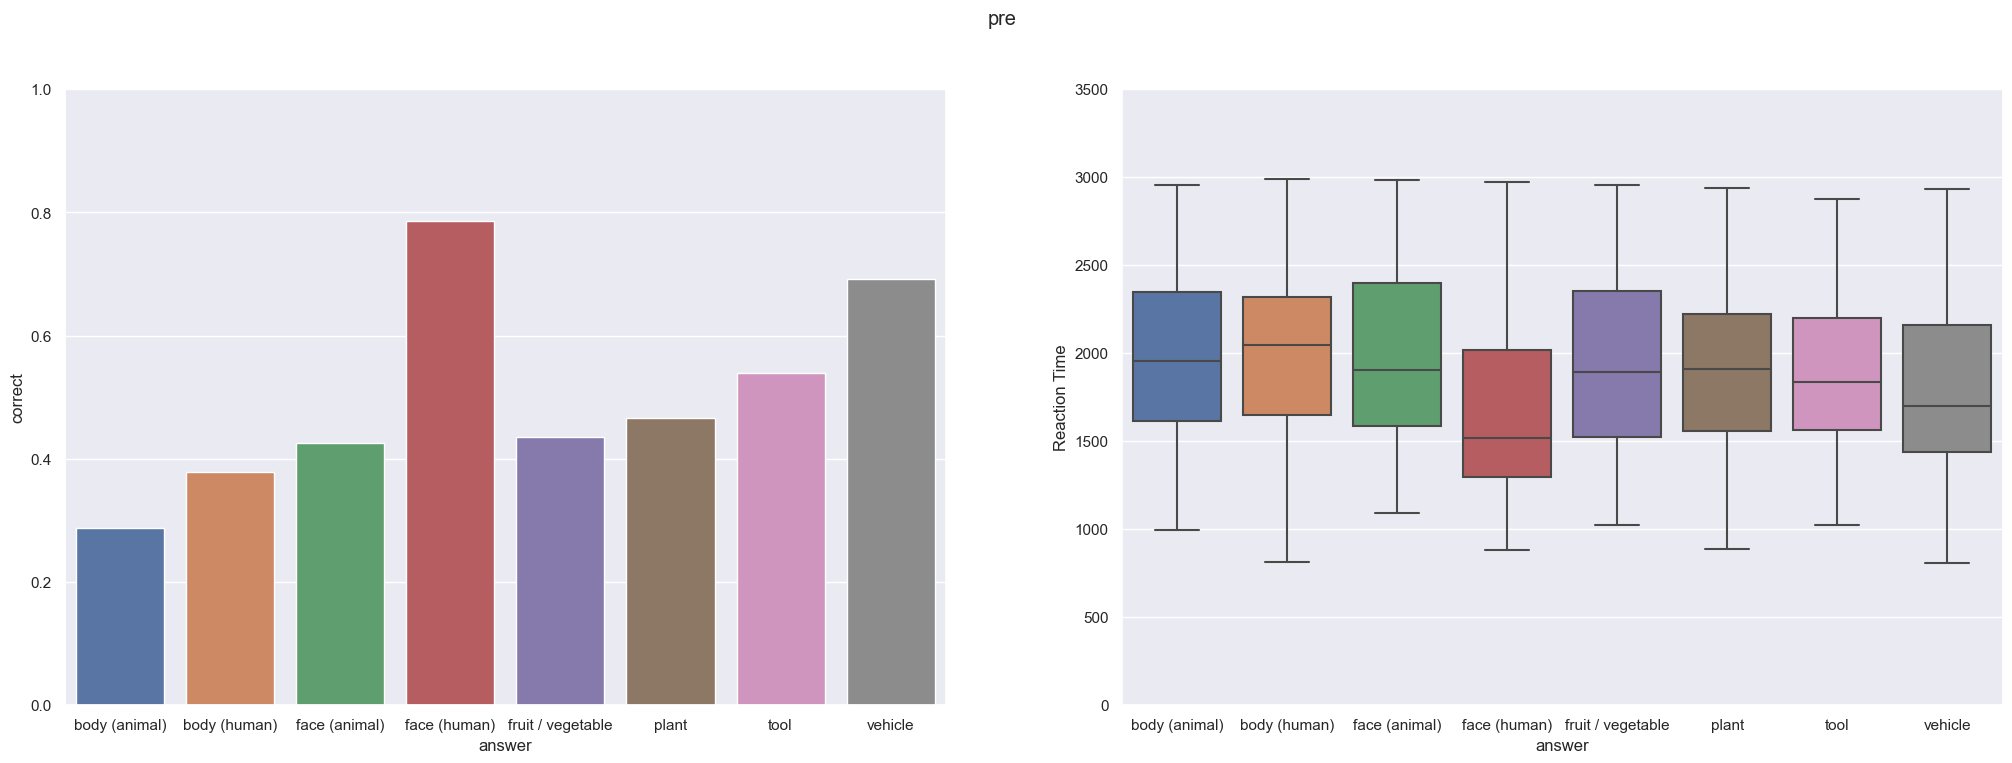

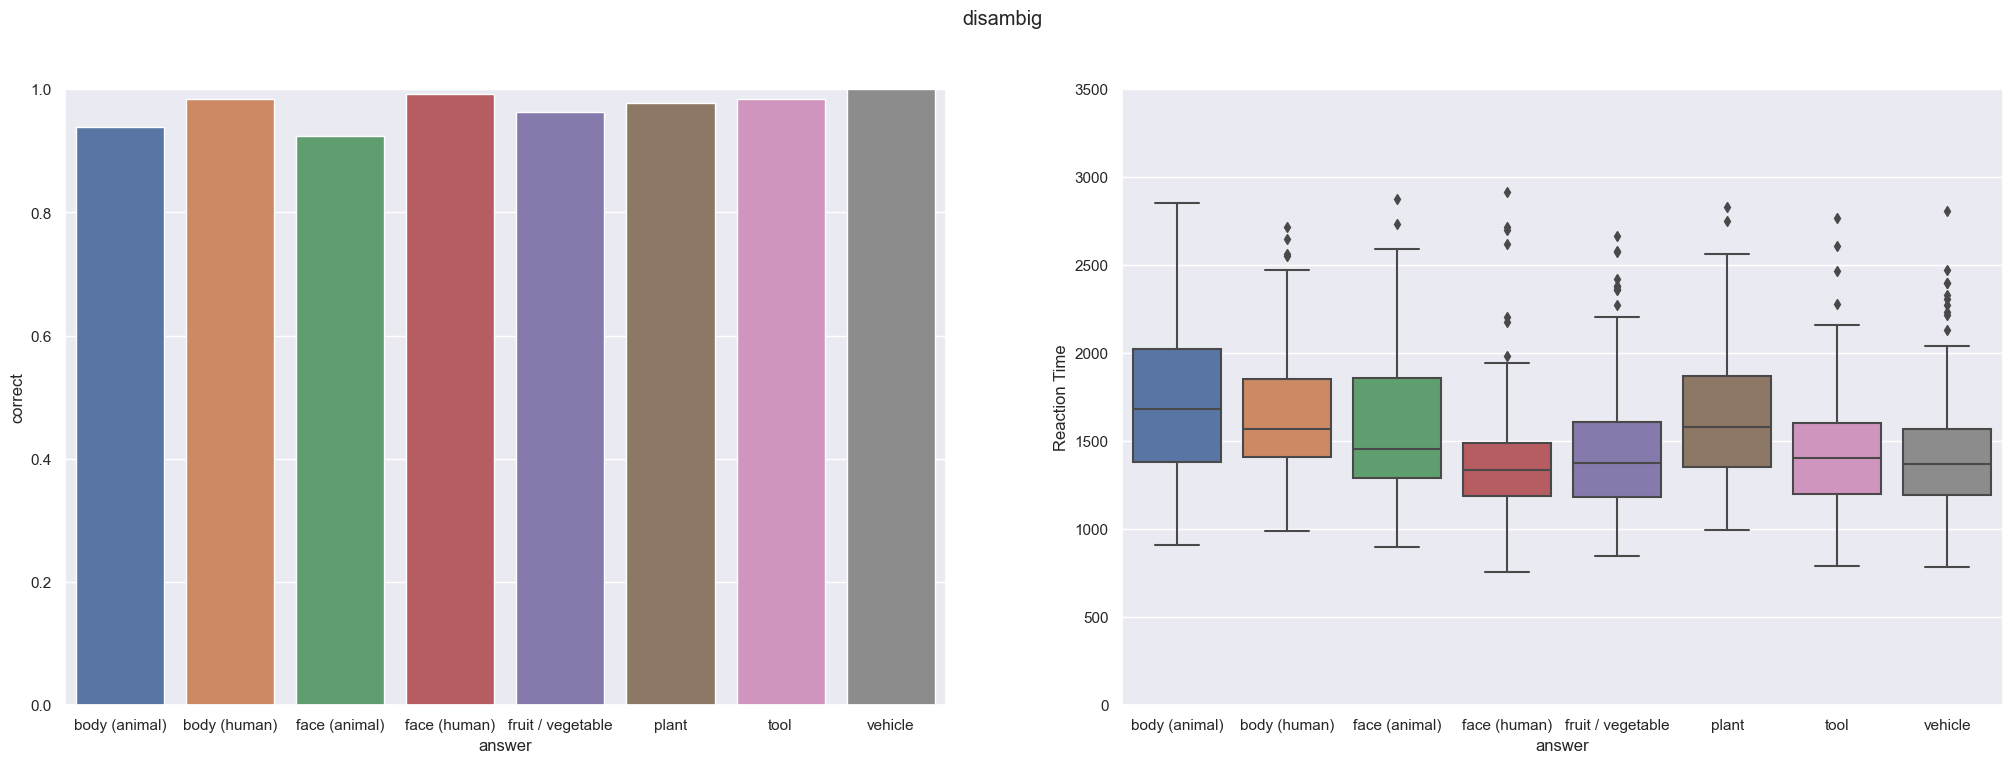

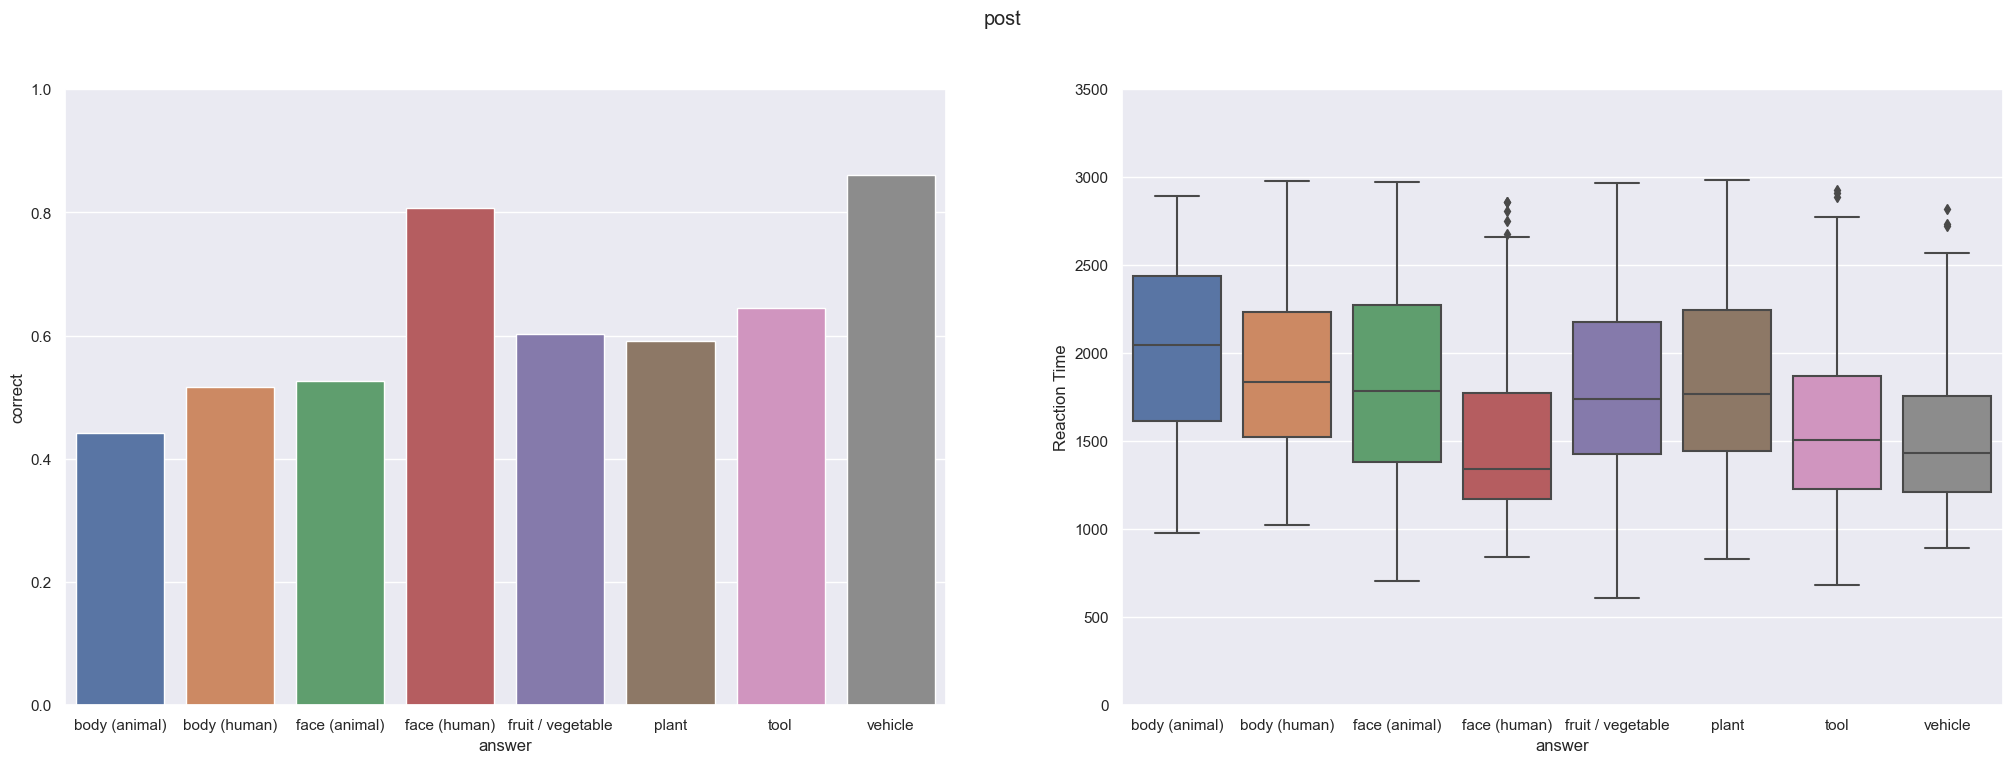

In [132]:
# by category - corectness + RTs

plot_categories(df_mooney_pre, "pre")
plot_categories(df_gray_disambig, "disambig")
plot_categories(df_mooney_post, "post")

### confusion mtx

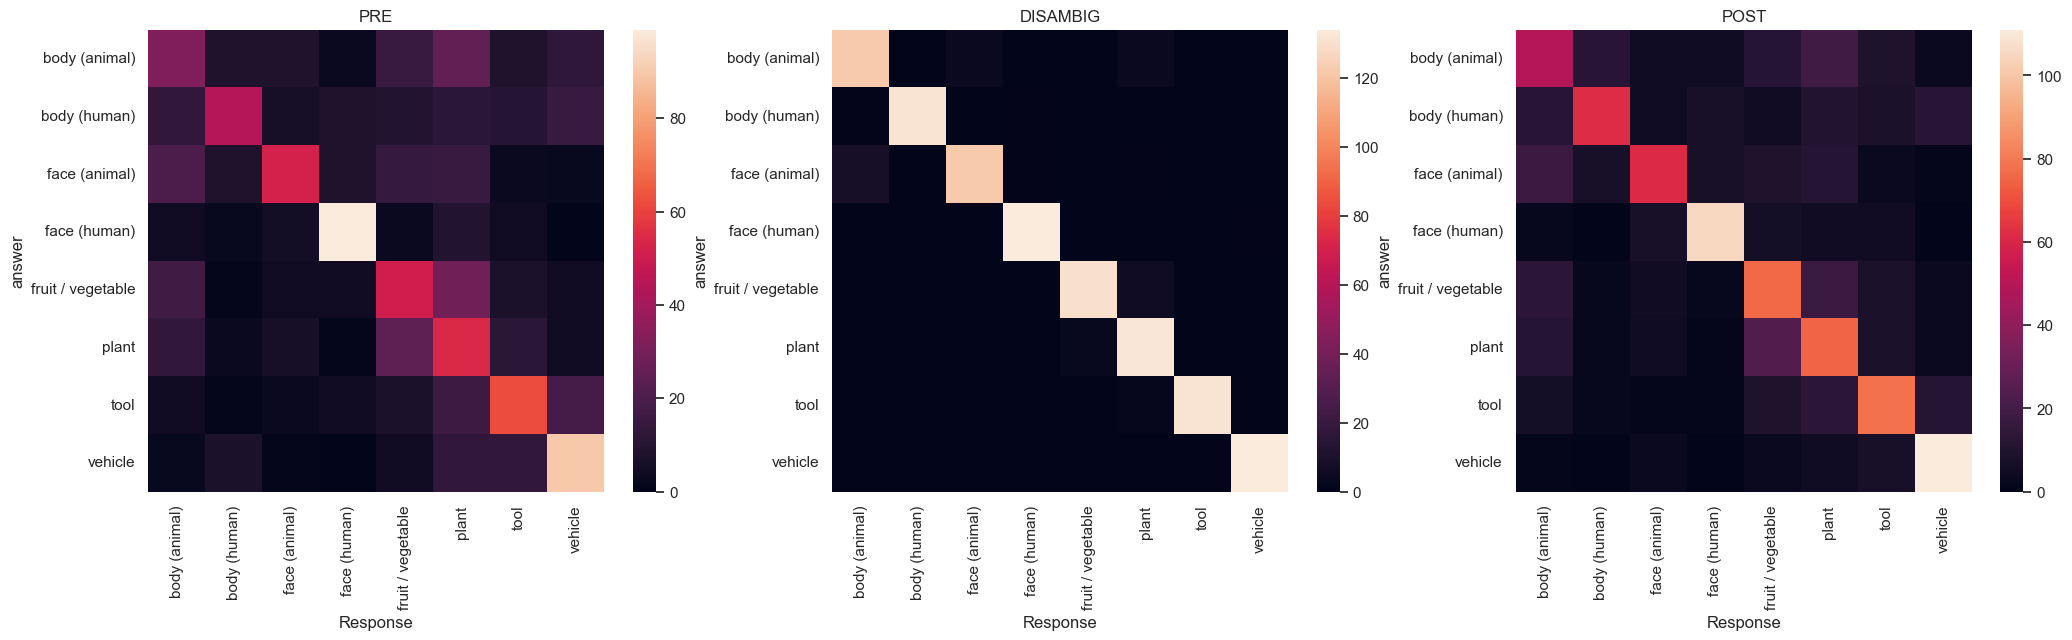

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
for i, df_ in enumerate((df_mooney_pre, df_gray_disambig, df_mooney_post)):
    crosstab = pd.crosstab(df_['answer'], df_['Response'])
    sns.heatmap(crosstab, ax=ax[i]).set_title(("PRE", "DISAMBIG", "POST")[i])

### paired differences pre x post

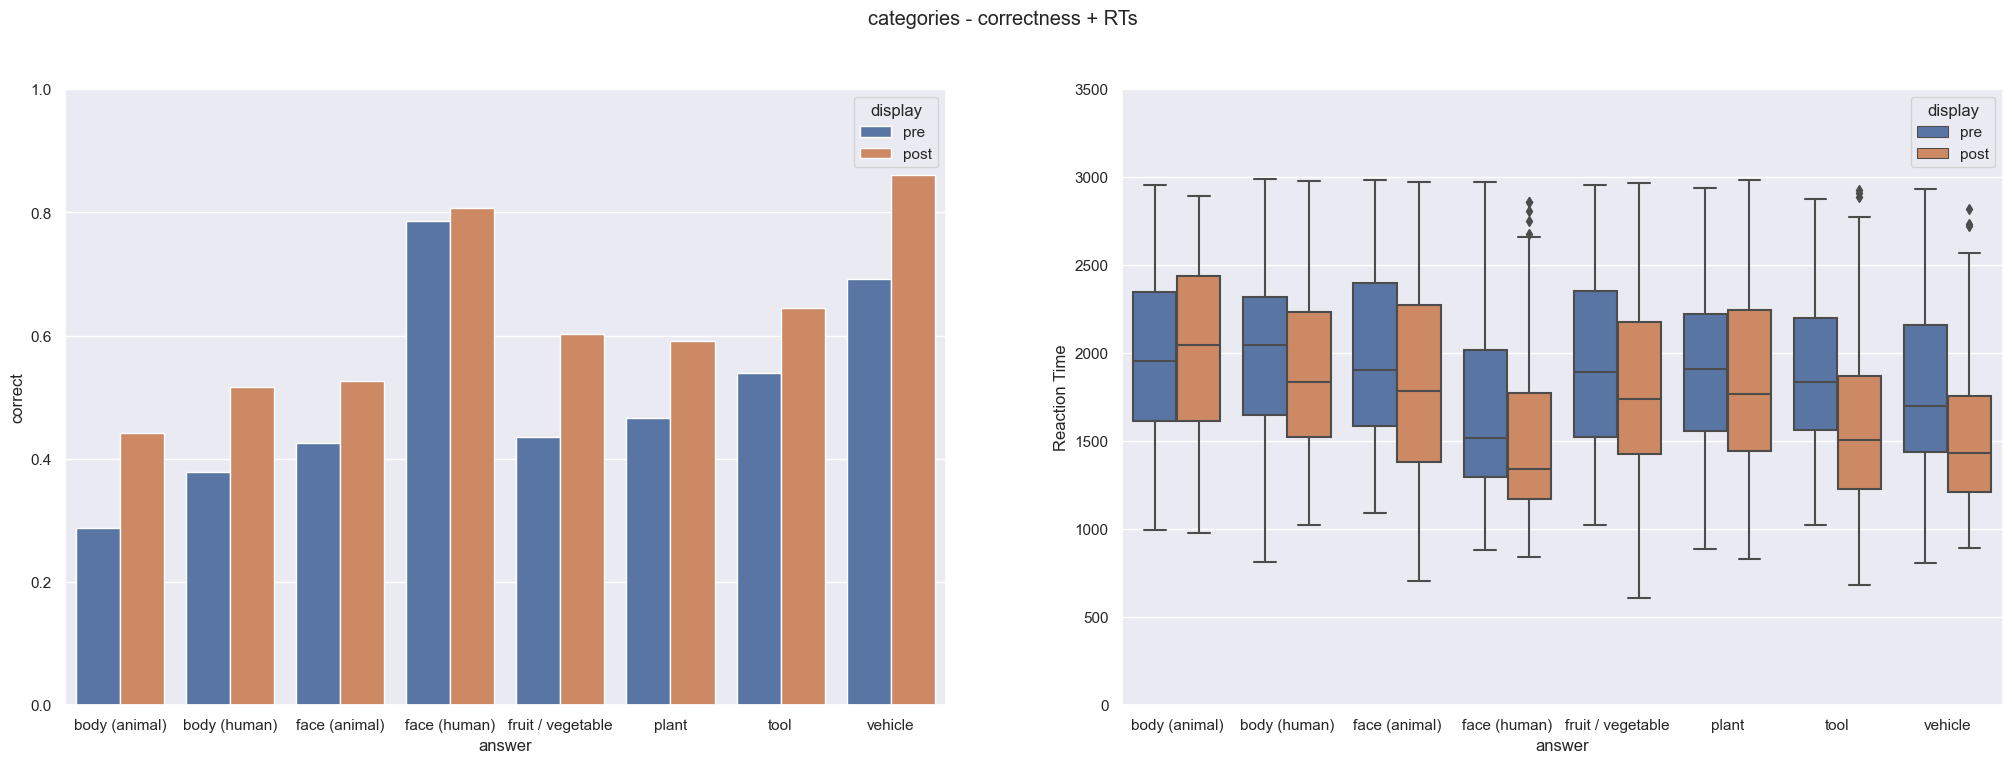

In [134]:
# % correct, RTs by category (paired)
plot_categories(pd.concat([df_mooney_pre, df_mooney_post]), 
                title="categories - correctness + RTs", 
                group=True)

/var/folders/_d/qvcv_ff152x0rbzkxc1g5q2r0000gn/T/ipykernel_10167/154604144.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[0].get_yticks()]);


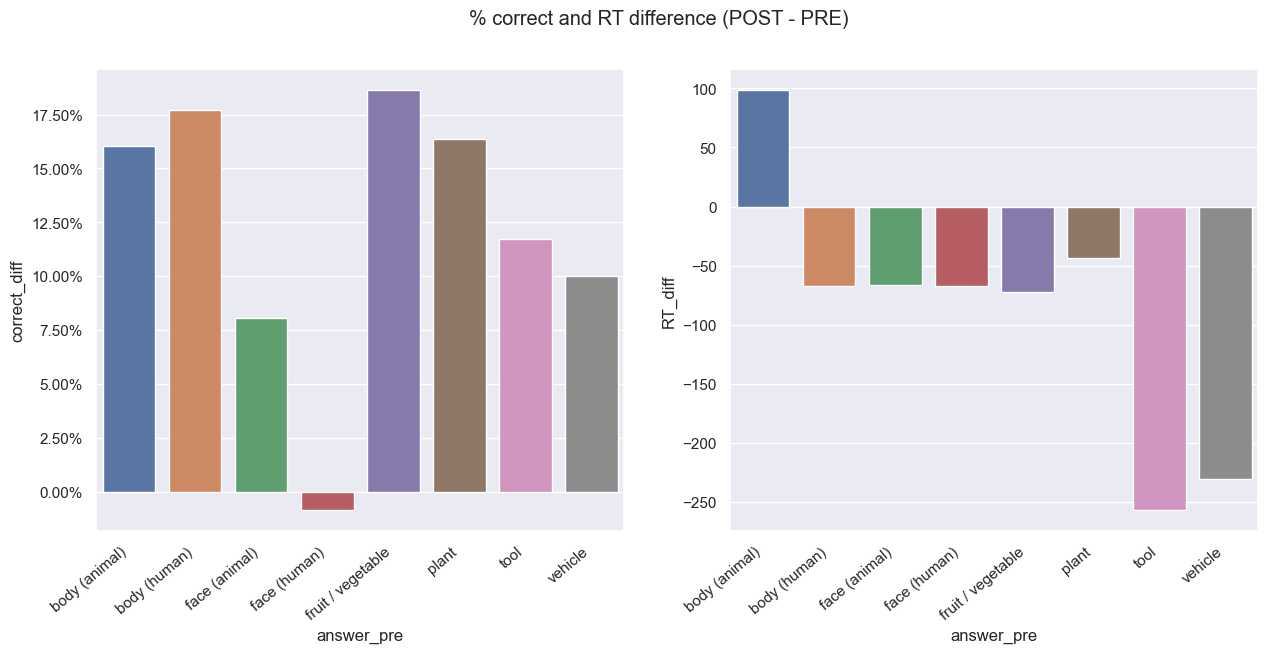

In [157]:
# paired difference - (pre - post) RT for each category, % correct
df_pre_post = pd.merge(left=df_mooney_pre, right=df_mooney_post, 
                        on='image', how='outer',
                        suffixes=('_pre', '_post'), 
                        # validate='1:1'
                        )
df_pre_post = (df_pre_post
                .assign(RT_diff=lambda x: x['Reaction Time_post'] - x['Reaction Time_pre'])
                .assign(correct_diff=lambda x: x['correct_post'] - x['correct_pre'])
                .loc[:, ['image', 'answer_pre', 'RT_diff', 'correct_diff']]
            )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle("% correct and RT difference (POST - PRE)")
sns.barplot(data=df_pre_post, x='answer_pre', y='RT_diff', order=CATEGORIES, errorbar=None, ax=ax[1])
sns.barplot(data=df_pre_post, x='answer_pre', y='correct_diff', order=CATEGORIES, errorbar=None, ax=ax[0])

ax[0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[0].get_yticks()]);
for i in range(2):
    ax[i].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right");

### search terms (keywords) & images

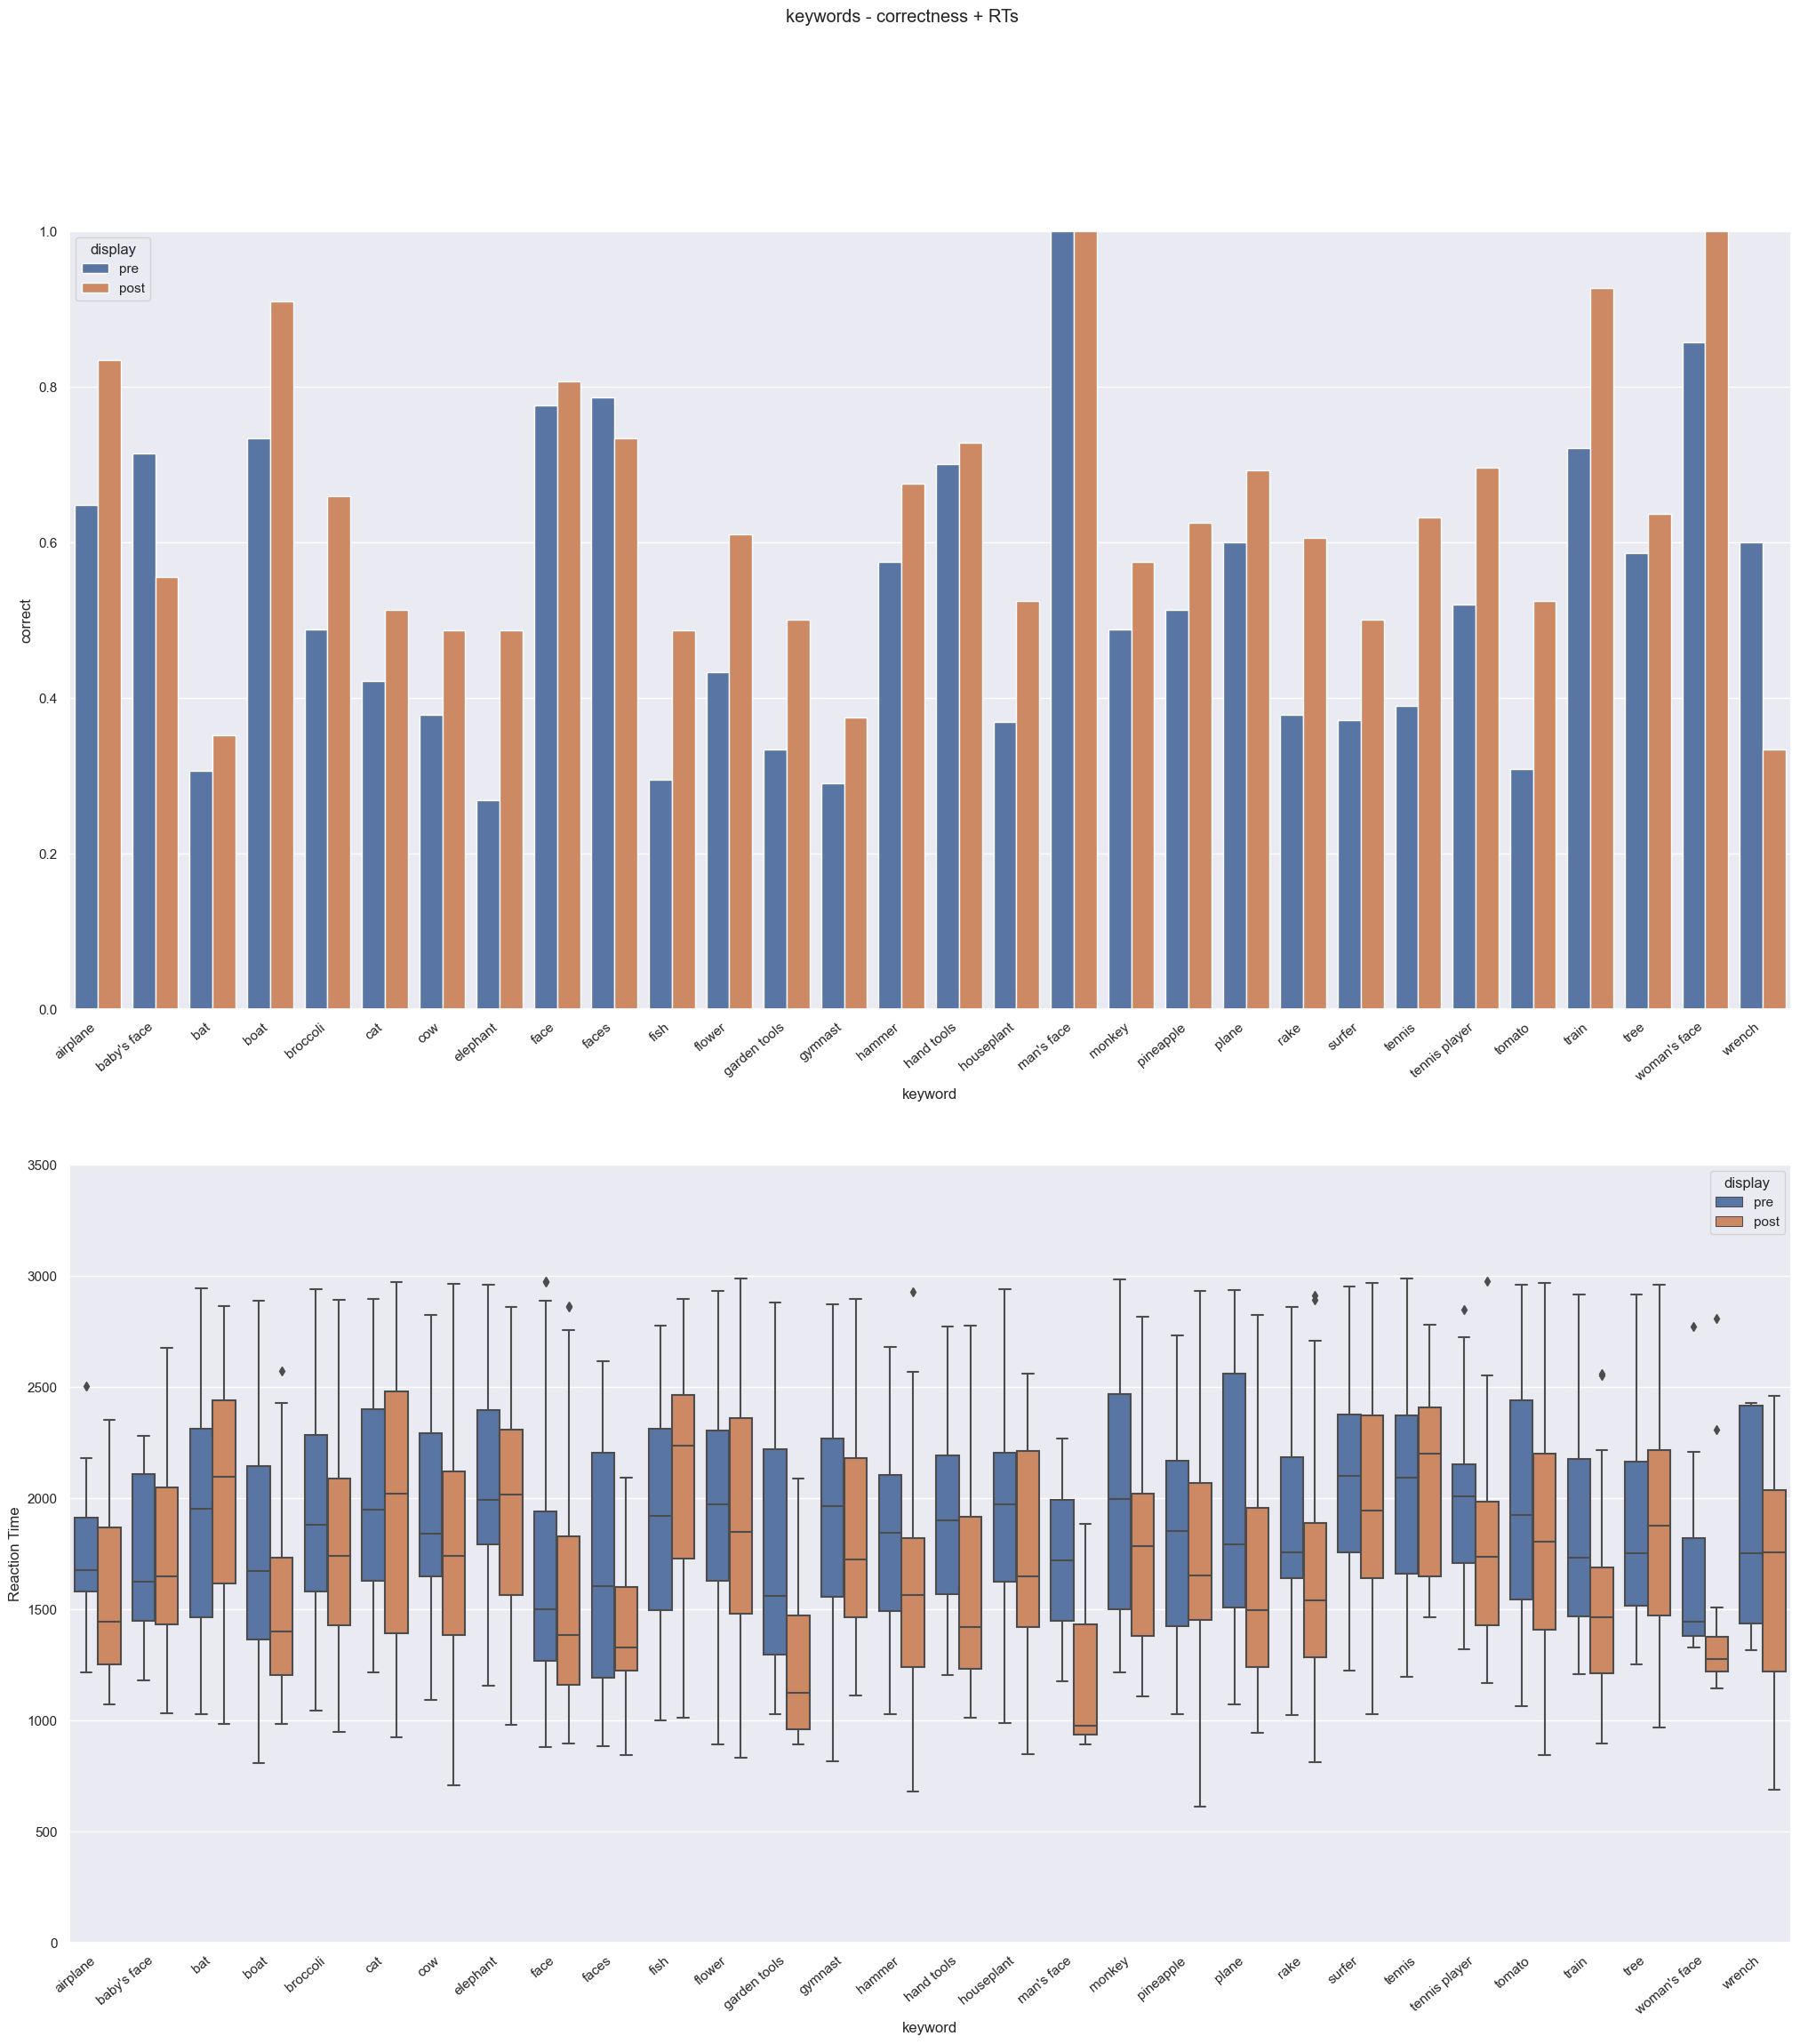

In [162]:
# PLOT for each search term (not subsearch)

plot_keywords(pd.concat([df_mooney_pre, df_mooney_post]), 
                title="keywords - correctness + RTs", 
                group=True)